In [2]:
# Patch the built-in open function to default to UTF-8
import builtins

# Save the original open function
_original_open = builtins.open

def utf8_open(file, mode='r', buffering=-1, encoding=None, errors=None, 
              newline=None, closefd=True, opener=None):
    # Force UTF-8 encoding for text mode files when encoding is not specified
    if 't' in str(mode) or encoding is None:
        if encoding is None:
            encoding = 'utf-8'
    return _original_open(file, mode, buffering, encoding, errors, newline, closefd, opener)

# Replace the built-in open
builtins.open = utf8_open



from convokit import Corpus, Speaker, Utterance, Conversation
from collections import Counter

In [3]:
DATA_FOLDER = "./dataset/question-evasion"
corpus = Corpus(DATA_FOLDER)
corpus.print_summary_stats()

Number of Speakers: 5
Number of Utterances: 6896
Number of Conversations: 3448


In [4]:
random_conversation = corpus.random_conversation()
print(random_conversation)

for u in random_conversation.iter_utterances():
    print(u)
    print("-"*100)


Conversation('id': 'Q_2442', 'utterances': ['Q_2442', 'A_2442'], 'meta': ConvoKitMeta({'title': "The President's News Conference", 'date': 'June 29, 2011', 'url': 'https://www.presidency.ucsb.edu/documents/the-presidents-news-conference-1111', 'president': 'Barack Obama', 'question_order': 3}))
Utterance(id: 'Q_2442', conversation_id: Q_2442, reply-to: None, speaker: Speaker(id: 'interviewer_generic', vectors: [], meta: ConvoKitMeta({'role': 'interviewer', 'name': 'Interviewer'})), timestamp: None, text: ' Constitutionality of the War Powers Act', vectors: [], meta: ConvoKitMeta({'type': 'question', 'question_order': 3, 'interview_question_raw': "Q. Thank you, Mr. President. There have been a lot of questions about the constitutionality--constitutional interpretations of a few decisions you've made, so I'll just simply ask: Do you believe the War Powers Act is constitutional? Do you believe that the debt limit is constitutional, the idea that Congress can do this? And do you believe th

In [5]:
def get_speaker_name(speaker_id):
    speaker = corpus.get_speaker(speaker_id)
    speaker_metadata = speaker.meta
    return speaker_metadata["name"]

In [6]:
def print_all_utterances_in_conversation(conv_id):
    conv = corpus.get_conversation(conv_id)
    conv_title = conv.meta.get("title")
    conv_date = conv.meta.get("date")
    president_name = conv.meta.get("president")
    print(f"{conv_title} ({conv_date}) - {president_name}")
    for utterance in conv.iter_utterances():
        text = utterance.text
        if utterance.meta.get("type") == "question":
            question_text = text
            speaker_name = get_speaker_name(utterance.speaker.id)
            raw_question_text = utterance.meta.get("interview_question_raw")
            question_order = utterance.meta.get("question_order")
            print(f"{speaker_name}: {question_text}")
            print(f"Raw question: {raw_question_text}")

        else:
            answer_text = text
            speaker_name = get_speaker_name(utterance.speaker.id)
            raw_answer_text = utterance.meta.get("interview_answer_raw")
            answer_label = utterance.meta.get("label")
            answer_inaudible = utterance.meta.get("inaudible")
            answer_multiple_questions = utterance.meta.get("multiple_questions")
            answer_affirmative_questions = utterance.meta.get("affirmative_questions")
            print(f"{speaker_name}: {answer_text}")
            print(f"Raw answer: {raw_answer_text}")
            print(f"Answer label: {answer_label}")
            print(f"Answer inaudible: {answer_inaudible}")
            print(f"Answer multiple questions: {answer_multiple_questions}")
            print(f"Answer affirmative questions: {answer_affirmative_questions}")
        print("\n")


In [7]:
all_conversations = corpus.get_conversation_ids()

In [8]:
for conv_id in all_conversations[:10]:
    print_all_utterances_in_conversation(conv_id)
    print("-"*100)


The President's News Conference in Hanoi, Vietnam (September 10, 2023) - Joseph R. Biden
Interviewer: How would you respond to the accusation that the United States is containing China while pushing for diplomatic talks?
Raw question: Q. Of the Biden administration. And accused the United States of containing China while pushing for diplomatic talks.How would you respond to that? And do you think President Xi is being sincere about getting the relationship back on track as he bans Apple in China?


Joseph R. Biden: Well, look, first of all, theI am sincere about getting the relationship right. And one of the things that is going on now is, China is beginning to change some of the rules of the game, in terms of trade and other issues.And so one of the things we talked about, for example, is that they're now talking about making sure that no Chineseno one in the Chinese Government can use a Western cell phone. Those kinds of things.And so, really, what this trip was aboutit was less abou

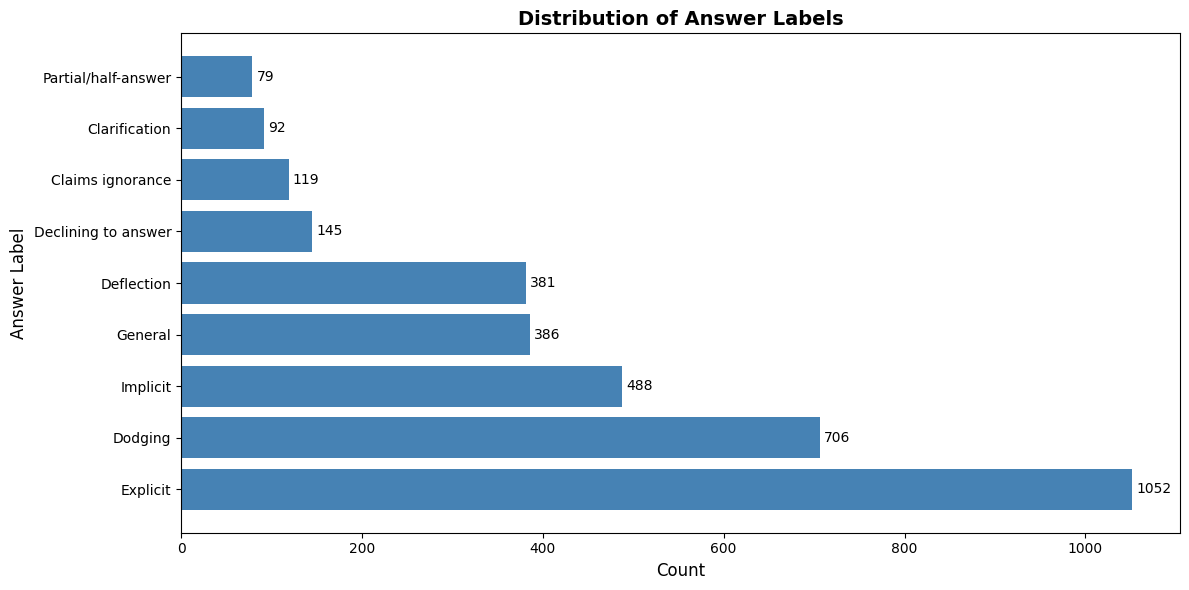

In [10]:
import matplotlib.pyplot as plt

a_labels = [u.meta.get("label") for u in corpus.iter_utterances() if u.meta.get("type")=="answer"]
label_counts = Counter(a_labels)
labels, counts = zip(*sorted(label_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
bars = plt.barh(labels, counts, color='steelblue')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Answer Label', fontsize=12)
plt.title('Distribution of Answer Labels', fontsize=14, fontweight='bold')

# Use bar_label instead
plt.bar_label(bars, padding=3)
plt.tight_layout()
plt.show()

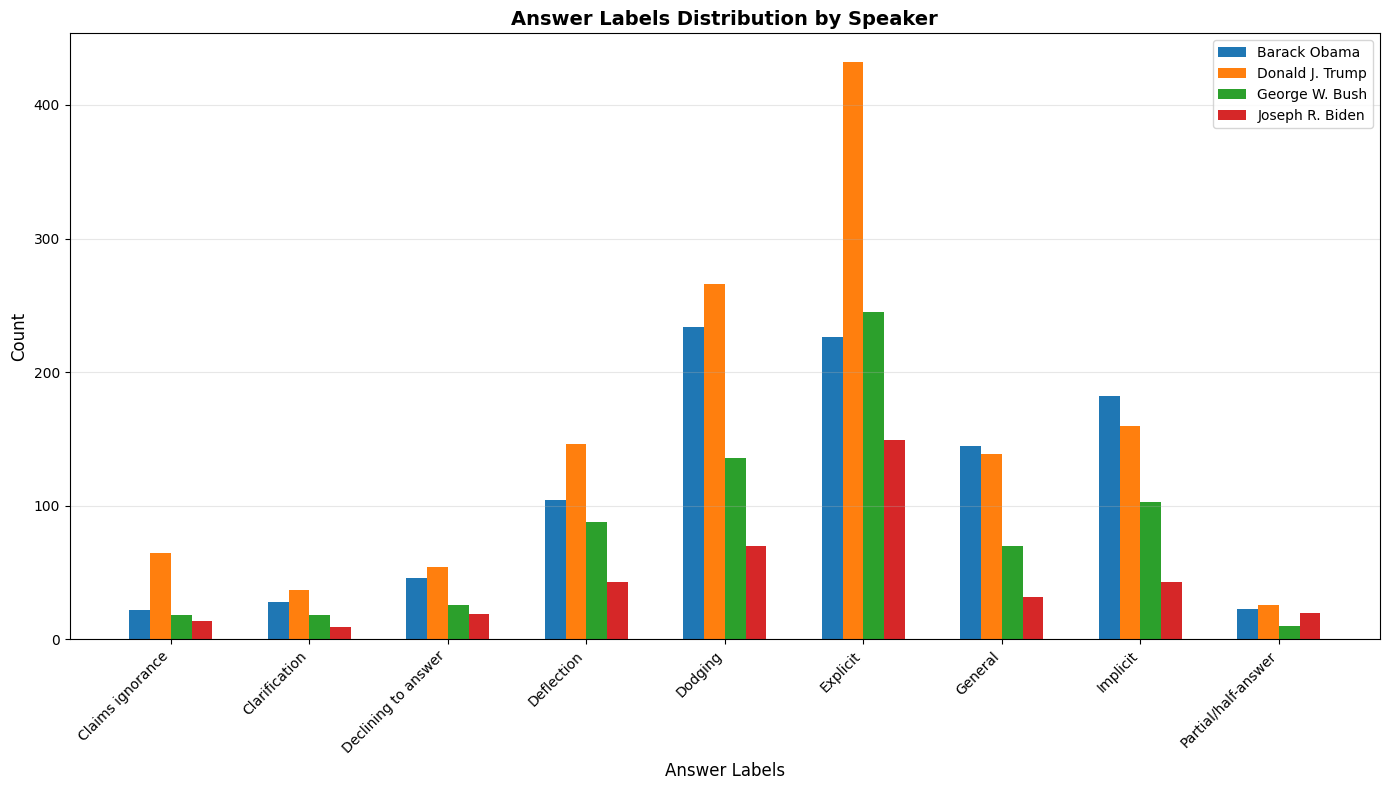

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Get all answer labels grouped by speaker
speaker_labels = defaultdict(list)
for u in corpus.iter_utterances():
    if u.meta.get("type") == "answer":
        speaker = corpus.get_speaker(u.speaker.id)
        speaker_name = speaker.meta.get("name")
        label = u.meta.get("label")
        speaker_labels[speaker_name].append(label)

# Create data structure for grouped bars
all_labels = set()
for labels in speaker_labels.values():
    all_labels.update(labels)
all_labels = sorted(all_labels)

speakers = sorted(speaker_labels.keys())
speaker_data = {speaker: [Counter(speaker_labels[speaker])[label] for label in all_labels] 
                for speaker in speakers}

# Create grouped bar chart
x = np.arange(len(all_labels))
width = 0.15  # width of bars

fig, ax = plt.subplots(figsize=(14, 8))

for i, speaker in enumerate(speakers):
    offset = (i - len(speakers)/2 + 0.5) * width
    ax.bar(x + offset, speaker_data[speaker], width, label=speaker)

ax.set_xlabel('Answer Labels', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Answer Labels Distribution by Speaker', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(all_labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

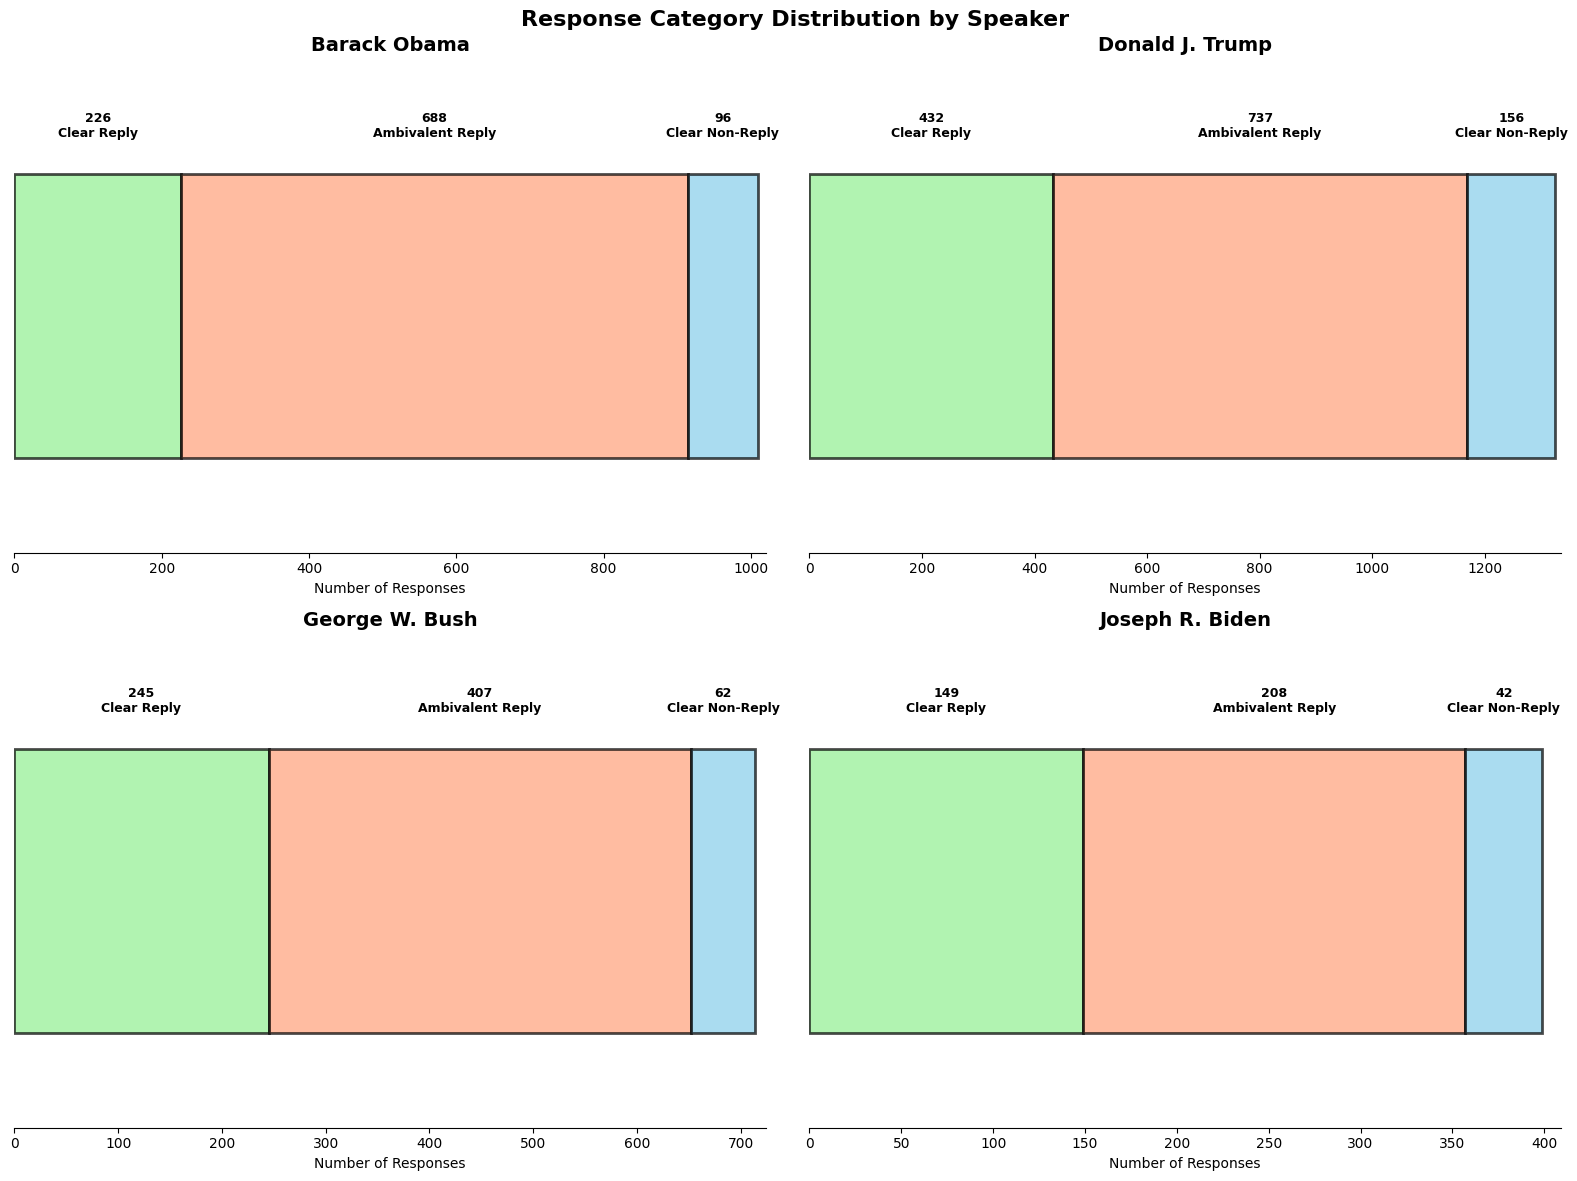


Detailed Breakdown:

Barack Obama:
  Clear Reply:
    Explicit: 226
  Ambivalent Reply:
    Dodging: 234
    Implicit: 182
    General: 145
    Deflection: 104
    Partial: 23
  Clear Non-Reply:
    Declining: 46
    Clarification: 28
    Ignorance: 22

Donald J. Trump:
  Clear Reply:
    Explicit: 432
  Ambivalent Reply:
    Dodging: 266
    Implicit: 160
    Deflection: 146
    General: 139
    Partial: 26
  Clear Non-Reply:
    Ignorance: 65
    Declining: 54
    Clarification: 37

George W. Bush:
  Clear Reply:
    Explicit: 245
  Ambivalent Reply:
    Dodging: 136
    Implicit: 103
    Deflection: 88
    General: 70
    Partial: 10
  Clear Non-Reply:
    Declining: 26
    Clarification: 18
    Ignorance: 18

Joseph R. Biden:
  Clear Reply:
    Explicit: 149
  Ambivalent Reply:
    Dodging: 70
    Implicit: 43
    Deflection: 43
    General: 32
    Partial: 20
  Clear Non-Reply:
    Declining: 19
    Ignorance: 14
    Clarification: 9


In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict, Counter
import numpy as np

# Define the hierarchical structure
category_mapping = {
    "Explicit": ("Clear Reply", "Explicit"),
    "Implicit": ("Ambivalent Reply", "Implicit"),
    "Dodging": ("Ambivalent Reply", "Dodging"),
    "General": ("Ambivalent Reply", "General"),
    "Deflection": ("Ambivalent Reply", "Deflection"),
    "Partial/half-answer": ("Ambivalent Reply", "Partial"),
    "Declining to answer": ("Clear Non-Reply", "Declining"),
    "Claims ignorance": ("Clear Non-Reply", "Ignorance"),
    "Clarification": ("Clear Non-Reply", "Clarification")
}

# Collect data per speaker
speaker_categories = defaultdict(lambda: {'Clear Reply': defaultdict(int), 
                                          'Ambivalent Reply': defaultdict(int),
                                          'Clear Non-Reply': defaultdict(int)})

for u in corpus.iter_utterances():
    if u.meta.get("type") == "answer":
        speaker = corpus.get_speaker(u.speaker.id)
        speaker_name = speaker.meta.get("name")
        label = u.meta.get("label")
        
        if label in category_mapping:
            top_cat, sub_cat = category_mapping[label]
            speaker_categories[speaker_name][top_cat][sub_cat] += 1

# Create visualization
speakers = sorted([s for s in speaker_categories.keys() if s != "Interviewer"])
top_categories = ['Clear Reply', 'Ambivalent Reply', 'Clear Non-Reply']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, speaker in enumerate(speakers):
    ax = axes[idx]
    
    # Calculate counts
    total_top = {cat: sum(speaker_categories[speaker][cat].values()) 
                 for cat in top_categories}
    
    # Create nested bar chart
    x_pos = 0
    colors = {'Clear Reply': '#90EE90', 'Ambivalent Reply': '#FFA07A', 
              'Clear Non-Reply': '#87CEEB'}
    
    bars_data = []
    labels_list = []
    
    for top_cat in top_categories:
        count = total_top[top_cat]
        if count > 0:
            bars_data.append((x_pos, count))
            labels_list.append(top_cat)
            x_pos += count + 5  # spacing between categories
    
    # Plot stacked bars for top categories
    prev_x = 0
    for i, (top_cat, (pos, count)) in enumerate(zip(top_categories, bars_data)):
        if count > 0:
            ax.barh(0, count, left=prev_x, height=0.6, color=colors[top_cat], 
                   label=top_cat if idx == 0 else "", 
                   edgecolor='black', linewidth=2, alpha=0.7)
            
            # Add sub-category breakdown as text inside or below
            sub_items = speaker_categories[speaker][top_cat]
            if len(sub_items) > 0:
                ax.text(prev_x + count/2, 0.4, 
                       f"{count}\n{top_cat}",
                       ha='center', va='center', fontsize=9, fontweight='bold')
            prev_x += count
    
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlim(0, prev_x + 10)
    ax.set_title(f'{speaker}', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Number of Responses', fontsize=10)
    ax.axes.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.suptitle('Response Category Distribution by Speaker', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\nDetailed Breakdown:")
print("="*80)
for speaker in speakers:
    print(f"\n{speaker}:")
    for top_cat in top_categories:
        items = speaker_categories[speaker][top_cat]
        if items:
            print(f"  {top_cat}:")
            for sub_cat, count in sorted(items.items(), key=lambda x: x[1], reverse=True):
                print(f"    {sub_cat}: {count}")